# Trigger efficiency with a skimmer

```
mkdir data/
scp -r cmslpc-sl7.fnal.gov:/eos/uscms/store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225150/0000/nano_mc2017_1-130.root data/nano_mc2017_1-130.root
```

Then, we import some libraries:

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Define the matching function:

In [2]:
def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

# def match_HWWlepqq(genparticles,candidatefj):
#     """
#     return the number of matched objects (hWW*),daughters, 
#     and gen flavor (enuqq, munuqq, taunuqq) 
#     """
#     W_PDGID = 24
#     HIGGS_PDGID = 25
#     higgs = getParticles(genparticles,HIGGS_PDGID)
#     is_hWW = ak.all(abs(higgs.children.pdgId)==W_PDGID,axis=2)

#     higgs = higgs[is_hWW]
#     higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
#     higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]
    
#     prompt_electron = getParticles(genparticles,11,11,['isPrompt','isLastCopy'])
#     prompt_muon = getParticles(genparticles,13,13,['isPrompt', 'isLastCopy'])
#     prompt_tau = getParticles(genparticles,15,15,['isPrompt', 'isLastCopy'])
#     prompt_q = getParticles(genparticles,0,5,['fromHardProcess', 'isLastCopy'])
#     prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == W_PDGID]
    
#     dr_fj_quarks = candidatefj.delta_r(prompt_q)
#     dr_fj_electrons = candidatefj.delta_r(prompt_electron)
#     dr_fj_muons = candidatefj.delta_r(prompt_muon)
#     dr_fj_taus = candidatefj.delta_r(prompt_tau)
#     dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)
#     hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)
    
#     n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
#     n_muons = ak.sum(prompt_muon.pt>0,axis=1)
#     n_taus = ak.sum(prompt_tau.pt>0,axis=1)
#     n_quarks = ak.sum(prompt_q.pt>0,axis=1)

#     # 4(elenuqq),6(munuqq),8(taunuqq)
#     hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7
    
#     matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
#     matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
#     matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8) 

#     # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
#     hWWlepqq_matched = (
#         (ak.sum(matchedH.pt > 0, axis=1)==1) * 1 
#         + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1)==1) * 3 
#         + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1)==1) * 5
#     )
    
#     # leptons matched
#     dr_leptons = ak.concatenate([dr_fj_electrons,dr_fj_muons], axis=1)
#     matched_leptons = dr_leptons < 0.8
    
#     leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
#     leptons = leptons[matched_leptons]
    
#     # leptons coming from W or W*
#     leptons_mass = ak.firsts(leptons.distinctParent.mass)
#     higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
#     higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

#     iswlepton = (leptons_mass == higgs_w_mass)
#     iswstarlepton = (leptons_mass == higgs_wstar_mass)
    
#     # let's return only:
#     # - matchedH (the higgs boson that is matched to the jet)
#     # - (iswlepton,iswstarlepton)
#     return matchedH,iswlepton,iswstarlepton



def match_HWW(genparticles, candidatefj):
    """
    return the number of matched objects (hWW*),daughters,
    and gen flavor (enuqq, munuqq, taunuqq)
    """
    higgs = getParticles(genparticles, 25)   # genparticles is the full set... this function selects Higgs particles
    is_hWW = ak.all(abs(higgs.children.pdgId) == 24, axis=2)    # W~24 so we get H->WW (limitation: only picking one W and assumes the other will be there)

    higgs = higgs[is_hWW]
#     higgs_wstar = higgs.children[ak.argmin(higgs.children.mass, axis=2, keepdims=True)]
#     higgs_w = higgs.children[ak.argmax(higgs.children.mass, axis=2, keepdims=True)]
#
#     prompt_electron = getParticles(genparticles, 11, 11, ['isPrompt', 'isLastCopy'])    # isPrompt avoids displaced leptons
#     prompt_muon = getParticles(genparticles, 13, 13, ['isPrompt', 'isLastCopy'])
#     prompt_tau = getParticles(genparticles, 15, 15, ['isPrompt', 'isLastCopy'])
#     prompt_q = getParticles(genparticles, 0, 5, ['fromHardProcess', 'isLastCopy'])      # 0-5 not 0-6 to avoid top quark
#     prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]       # parent W

#     dr_fj_quarks = candidatefj.delta_r(prompt_q)
#     dr_fj_electrons = candidatefj.delta_r(prompt_electron)
#     dr_fj_muons = candidatefj.delta_r(prompt_muon)
#     dr_fj_taus = candidatefj.delta_r(prompt_tau)
#     dr_daughters = ak.concatenate([dr_fj_quarks, dr_fj_electrons, dr_fj_muons, dr_fj_taus], axis=1)
#     hWW_nprongs = ak.sum(dr_daughters < 0.8, axis=1)   # impose that something must be inside the cone... tells you # of particles from Higgs matched to the jet

#     n_electrons = ak.sum(prompt_electron.pt > 0, axis=1)
#     n_muons = ak.sum(prompt_muon.pt > 0, axis=1)
#     n_taus = ak.sum(prompt_tau.pt > 0, axis=1)
#     n_quarks = ak.sum(prompt_q.pt > 0, axis=1)

#     # 4(elenuqq),6(munuqq),8(taunuqq)
#     hWW_flavor = (n_quarks == 2) * 1 + (n_electrons == 1) * 3 + (n_muons == 1) * 5 + (n_taus == 1) * 7 + (n_quarks == 4) * 11

    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)    # choose higgs closest to fj
#     matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)  # choose W closest to fj
#     matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8)  # choose Wstar closest to fj

#     # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
#     hWW_matched = (
#         (ak.sum(matchedH.pt > 0, axis=1) == 1) * 1
#         + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1) == 1) * 3
#         + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1) == 1) * 5
#     )

#     # leptons matched
#     dr_fj_leptons = ak.concatenate([dr_fj_electrons, dr_fj_muons], axis=1)

#     leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
#     leptons = leptons[dr_fj_leptons < 0.8]

#     # leptons coming from W or W*
#     leptons_mass = ak.firsts(leptons.distinctParent.mass)   # # TODO: why need firsts
#     higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
#     higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

#     iswlepton = (leptons_mass == higgs_w_mass)
#     iswstarlepton = (leptons_mass == higgs_wstar_mass)

#     genVars = {
#         "hWW_flavor": hWW_flavor,
#         "hWW_matched": hWW_matched,
#         "hWW_nprongs": hWW_nprongs,
#         "matchedH": matchedH,
#         "iswlepton": iswlepton,  # truth info, higher mass is normally onshell
#         "iswstarlepton": iswstarlepton}  # truth info, lower mass is normally offshell
    
#     return genVars

    return matchedH

Now, let's define a processor:

In [3]:
import numpy as np
import pandas as pd
from coffea.processor import ProcessorABC, column_accumulator
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
    
# "ele": [
#     "Ele35_WPTight_Gsf",
#     "Ele115_CaloIdVT_GsfTrkIdT",
#     "Photon200"
# ],
# "mu": [
#     "Mu50",
#     "IsoMu27",
#     "OldMu100",
#     "TkMu100"
# ],
    
class TriggerEfficienciesProcessor(ProcessorABC):
    """ Accumulates histograms from all input events: 1) before triggers, and 2) after triggers """
    def __init__(self, year=2017):
        super(TriggerEfficienciesProcessor, self).__init__()
        self._year = year
        self._trigger_dict = {
            2017:{
                "ele35": [
                    "Ele35_WPTight_Gsf",
                ],
                "ele115": [
                    "Ele115_CaloIdVT_GsfTrkIdT"
                ],
                "Photon200": [
                    "Photon200"
                ],
                "Mu50": [
                    "Mu50",
                ],
                "IsoMu27": [
                    "IsoMu27"
                ],
                "OldMu100": [
                    "OldMu100"
                ],
               "TkMu100": [
                    "TkMu100"
                ],                
            }
        }[self._year]
        self._triggers = {"ele": ["ele35","ele115","Photon200"],
                          "mu": ["Mu50","IsoMu27","OldMu100","TkMu100"],
                         }
        
        self._channels = ["ele","mu"]
    
    def pad_val(
        self, arr: ak.Array, target: int, value: float, axis: int = 0, to_numpy: bool = True
    ):
        """pads awkward array up to `target` index along axis `axis` with value `value`, optionally converts to numpy array"""
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=True), value)
        return ret.to_numpy() if to_numpy else ret
    
    def process(self, events):
        """ Returns pre- (den) and post- (num) trigger histograms from input NanoAOD events """
        dataset = events.metadata['dataset']
        n_events = len(events)
        isRealData = not hasattr(events, "genWeight")
        
        def pad_val_nevents(arr: ak.Array):
            """pad values with the length equal to the number of events"""
            return self.pad_val(arr, n_events, -1)
    
        # skimmed events for different channels
        out = {}
        for channel in self._channels:
            out[channel] = {}

        """ Save OR of triggers as booleans """
        for channel in self._channels:
            HLT_triggers = {}
            for t in self._triggers[channel]:
                HLT_triggers["HLT_"+t] = np.any(
                        np.array(
                            [
                                events.HLT[trigger] for trigger in self._trigger_dict[t] if trigger in events.HLT.fields
                            ]
                        ),
                        axis=0,
                )                
            out[channel] = {**out[channel], **HLT_triggers}

        """ Baseline selection """
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP90)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        
        # taus (will need to refine to avoid overlap with htt)
        loose_taus_mu = (events.Tau.pt > 20) & (abs(events.Tau.eta) < 2.3) & (events.Tau.idAntiMu >= 1)  # loose antiMu ID
        loose_taus_ele = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEleDeadECal >= 2)  # loose Anti-electron MVA discriminator V6 (2018) ?
        )
        n_loose_taus_mu = ak.sum(loose_taus_mu, axis=1)
        n_loose_taus_ele = ak.sum(loose_taus_ele, axis=1)

        # leading lepton
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        
        # fatjet closest to MET
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200) &
            (abs(fatjets.eta) < 2.4)
        ]
        met = events.MET
        dphi_met_fj = abs(candidatefj.delta_phi(met))
        candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        dr_lep_fj = candidatefj.delta_r(candidatelep)

        # jets
        jets = events.Jet
        candidatejet = jets[
            (jets.pt > 30) 
            & (abs(jets.eta) < 2.5) 
            & jets.isTight
        ]
        
        # define isolation
        mu_iso = ak.where(candidatelep.pt >= 55., candidatelep.miniPFRelIso_all, candidatelep.pfRelIso03_all)
        ele_iso = ak.where(candidatelep.pt >= 120., candidatelep.pfRelIso03_all, candidatelep.pfRelIso03_all)
        
        # define selections for different channels
        for channel in self._channels:
            selection = PackedSelection()
            selection.add('fjkin', candidatefj.pt > 200)
            if channel=="mu":
                selection.add('onemuon', (nmuons == 1) & (nelectrons == 0) & (n_loose_taus_mu == 0))
                selection.add('muonkin', (candidatelep.pt > 27.) & abs(candidatelep.eta < 2.4))
            elif channel=="ele":
                selection.add('oneelectron', (nelectrons == 1) & (nmuons == 0) & (n_loose_taus_ele == 0))
                selection.add('electronkin', (candidatelep.pt > 30.) & abs(candidatelep.eta < 2.4))

            """ Define other variables to save """
            out[channel]["fj_pt"] = pad_val_nevents(candidatefj.pt)
            out[channel]["fj_msoftdrop"] = pad_val_nevents(candidatefj.msoftdrop)
            out[channel]["lep_pt"] = pad_val_nevents(candidatelep.pt)
#             if channel=="mu":
#                 out[channel]["lep_isolation"] = pad_val_nevents(mu_iso)
#             elif channel=="ele":
#                 out[channel]["lep_isolation"] = pad_val_nevents(ele_iso)
#             out[channel]["fj_lep_mass"] = pad_val_nevents((candidatefj - candidatelep).mass)
#             out[channel]["fj_lep_dR"] = pad_val_nevents(dr_lep_fj)
#             out[channel]["ht"] = pad_val_nevents(ak.sum(candidatejet.pt, axis=1))
            
            if "HToWW" in dataset:
#                 matchedH,iswlepton,iswstarlepton = match_HWWlepqq(events.GenPart,candidatefj)
                matchedH = match_HWW(events.GenPart,candidatefj)
                matchedH_pt = ak.firsts(matchedH.pt)
            else:
                matchedH_pt = ak.zeros_like(candidatefj.pt)
#                 iswlepton = ak.ones_like(candidatefj.pt, dtype=bool)
#                 iswstarlepton = ak.ones_like(candidatefj.pt, dtype=bool)
            out[channel]["higgspt"] = pad_val_nevents(matchedH_pt)
#             out[channel]["iswlepton"] = pad_val_nevents(iswlepton)
#             out[channel]["iswstarlepton"] = pad_val_nevents(iswstarlepton)

            # use column accumulators
            out[channel] = {
                key: column_accumulator(value[selection.all(*selection.names)])
                for (key, value) in out[channel].items()
            }
        
        return {
            self._year: {
                dataset: {"nevents": n_events, "skimmed_events": out}
            }
        }

                  
    def postprocess(self, accumulator):
        for year, datasets in accumulator.items():
            for dataset, output in datasets.items():
                for channel in output["skimmed_events"].keys():
                    output["skimmed_events"][channel] = {
                        key: value.value for (key, value) in output["skimmed_events"][channel].items()
                    }
                
        return accumulator

In [ ]:
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

from coffea.processor import IterativeExecutor,Runner,DaskExecutor

# define fileset
# fileset = {"HToWW": ["nano_mc2017_1-1.root"]}    ### if you have the file locally
fileset = {"HToWW": ["data/hww_1.root", "data/hww_2.root"]}    ### if you have the file locally

# fileset = {"HToWW": ["root://xcache/"+ filename]}         ### if you read it through xrootd

# define processor
# here you can change "triggers" to have more options: e.g. nominal,jet ...
p = TriggerEfficienciesProcessor(year=2017)
# p = HwwProcessor(year=2017)

# define iterative executor (to run locally)
executor = IterativeExecutor(compression=1, status=True, workers=1)

# define the runner (with NanoAODSchema)
run = Runner(executor=executor,savemetrics=True,chunksize=10000,schema=NanoAODSchema)

# run 
out,metrics = run(fileset,'Events',processor_instance=p)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

## ELECTRON CHANNEL

In [45]:
! ls trigger/GluGluHToWWToLNuQQ

0-35.pkl 1-36.pkl 2-37.pkl


In [198]:
import pickle as pkl
import glob

samples = ['GluGluHToWWToLNuQQ']
triggers = ['HLT_ele35', 'HLT_ele115', 'HLT_Photon200']

# load samples
for sample in samples:
    
    tot = {}
    for trigger in triggers:
        tot[trigger] = []

    pkl_files = glob.glob(f'trigger/{sample}/*')
    
    for i, pkl_file in enumerate(pkl_files):
        with open(f'{pkl_file}', 'rb') as f:
            out = pkl.load(f)

        skimmed_events = out[2017][f"{sample}"]["skimmed_events"]["ele"]

        for key, value in skimmed_events.items():
            skimmed_events[key] = value.value    # convert from column accumulator to numpy regular array
        
        if i==0:
            for trigger in triggers:
                tot[trigger] = skimmed_events[trigger]
                        
            fj_pt = skimmed_events['fj_pt']
            fj_msoftdrop = skimmed_events['fj_msoftdrop']
            lep_pt = skimmed_events['lep_pt']
            higgs_pt = skimmed_events['higgspt']
        else:
            for trigger in triggers:
                tot[trigger] =  np.concatenate([tot[trigger], skimmed_events[trigger]])

            fj_pt = np.concatenate([fj_pt, skimmed_events['fj_pt']])
            fj_msoftdrop = np.concatenate([fj_msoftdrop, skimmed_events['fj_msoftdrop']])
            lep_pt = np.concatenate([lep_pt, skimmed_events['lep_pt']])
            higgs_pt = np.concatenate([higgs_pt, skimmed_events['higgspt']]) 

In [203]:
# now we can make histograms for higgspt, jetpt, leptonpt
import hist as hist2
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)

hpt_axis = hist2.axis.Regular(25, 100, 700, name='higgspt', label=r'matched H $p_T$ [GeV]')
leppt_axis = hist2.axis.Regular(15, 10, 400, name='leppt', label=r'Lepton $p_T$ [GeV]')

hists = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                hpt_axis,
                leppt_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
hists.fill(
    channel="ele",
    region="denominator",
    trigger="all",
    higgspt=higgs_pt,
    leppt=lep_pt,
)
hists.fill(
    channel="ele",
    region="numerator",
    trigger="ele35",
    higgspt=higgs_pt[tot["HLT_ele35"]],
    leppt=lep_pt[tot["HLT_ele35"]],

)
hists.fill(
    channel="ele",
    region="numerator",
    trigger="ele115",
    higgspt=higgs_pt[tot["HLT_ele115"]],
    leppt=lep_pt[tot["HLT_ele115"]], 
)

hists.fill(
    channel="ele",
    region="numerator",
    trigger="Photon200",
    higgspt=higgs_pt[tot["HLT_Photon200"]],
    leppt=lep_pt[tot["HLT_Photon200"]],   
)

hists

Hist(
  StrCategory(['ele'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  StrCategory(['all', 'ele35', 'ele115', 'Photon200'], growth=True, name='trigger', label='trigger'),
  Regular(25, 100, 700, name='higgspt', label='matched H $p_T$ [GeV]'),
  Regular(15, 10, 400, name='leppt', label='Lepton $p_T$ [GeV]'),
  storage=Double()) # Sum: 34971.0 (70506.0 with flow)

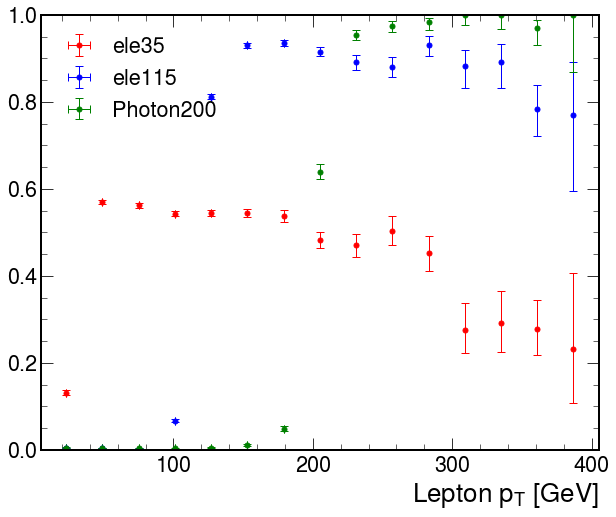

In [204]:
# now we plot trigger efficiency as function of jetpt
num_35 = hists[{"region":"numerator", "channel":"ele", "trigger":"ele35", 'higgspt':sum}]
num_115 = hists[{"region":"numerator", "channel":"ele", "trigger":"ele115", 'higgspt':sum}]
num_photon = hists[{"region":"numerator", "channel":"ele", "trigger":"Photon200", 'higgspt':sum}]

den = hists[{"region":"denominator", "channel":"ele", "trigger":sum, 'higgspt':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(figsize=(10,8))
hep.histplot(num_35/den,
             ax = ax,
             color='red', 
             label="ele35",
             histtype='errorbar', 
             yerr=get_yerr(num_35, den),
             capsize=4, 
             elinewidth=1,              
)
hep.histplot(num_115/den, 
             ax = ax,
             color='blue', 
             label="ele115",             
             histtype='errorbar', 
             yerr=get_yerr(num_115, den),
             capsize=4,  
             elinewidth=1, 
)
hep.histplot(num_photon/den, 
             ax = ax,
             color='green', 
             label="Photon200",
             histtype='errorbar', 
             yerr=get_yerr(num_photon, den),    
             capsize=4,   
             elinewidth=1,              
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig(f'trigger/leppt_ele.pdf');

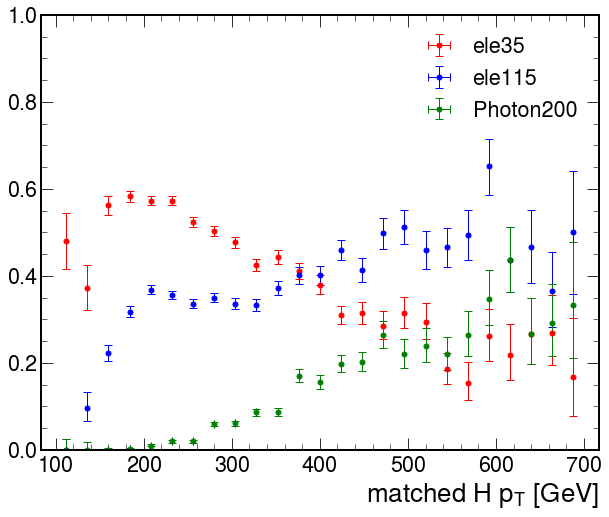

In [205]:
# now we plot trigger efficiency as function of jetpt
num_35 = hists[{"region":"numerator", "channel":"ele", "trigger":"ele35", 'leppt':sum}]
num_115 = hists[{"region":"numerator", "channel":"ele", "trigger":"ele115", 'leppt':sum}]
num_photon = hists[{"region":"numerator", "channel":"ele", "trigger":"Photon200", 'leppt':sum}]

den = hists[{"region":"denominator", "channel":"ele", "trigger":sum, 'leppt':sum}]

import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(figsize=(10,8))
hep.histplot(num_35/den, 
             ax = ax,
             color='red', 
             label="ele35",
             histtype='errorbar', 
             yerr=get_yerr(num_35, den),
             capsize=4, 
             elinewidth=1,              
)
hep.histplot(num_115/den, 
             ax = ax,
             color='blue', 
             label="ele115",             
             histtype='errorbar', 
             yerr=get_yerr(num_115, den),
             capsize=4,  
             elinewidth=1, 
)
hep.histplot(num_photon/den, 
             ax = ax,
             color='green', 
             label="Photon200",
             histtype='errorbar', 
             yerr=get_yerr(num_photon, den),    
             capsize=4,   
             elinewidth=1,              
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig(f'trigger/higgspt_ele.pdf');

## MUON CHANNEL

In [207]:
import pickle as pkl
import glob

samples = ['GluGluHToWWToLNuQQ']
triggers = ['HLT_Mu50', 'HLT_IsoMu27', 'HLT_OldMu100', 'HLT_TkMu100']

# load samples
for sample in samples:
    
    tot = {}
    for trigger in triggers:
        tot[trigger] = []

    pkl_files = glob.glob(f'trigger/{sample}/*')
    
    for i, pkl_file in enumerate(pkl_files):
        with open(f'{pkl_file}', 'rb') as f:
            out = pkl.load(f)

        skimmed_events = out[2017][f"{sample}"]["skimmed_events"]["mu"]

        for key, value in skimmed_events.items():
            skimmed_events[key] = value.value    # convert from column accumulator to numpy regular array
        
        if i==0:
            for trigger in triggers:
                tot[trigger] = skimmed_events[trigger]
                        
            fj_pt = skimmed_events['fj_pt']
            fj_msoftdrop = skimmed_events['fj_msoftdrop']
            lep_pt = skimmed_events['lep_pt']
            higgs_pt = skimmed_events['higgspt']
        else:
            for trigger in triggers:
                tot[trigger] =  np.concatenate([tot[trigger], skimmed_events[trigger]])

            fj_pt = np.concatenate([fj_pt, skimmed_events['fj_pt']])
            fj_msoftdrop = np.concatenate([fj_msoftdrop, skimmed_events['fj_msoftdrop']])
            lep_pt = np.concatenate([lep_pt, skimmed_events['lep_pt']])
            higgs_pt = np.concatenate([higgs_pt, skimmed_events['higgspt']]) 

In [208]:
# now we can make histograms for higgspt, jetpt, leptonpt
import hist as hist2
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)

hpt_axis = hist2.axis.Regular(25, 100, 700, name='higgspt', label=r'matched H $p_T$ [GeV]')
leppt_axis = hist2.axis.Regular(20, 10, 400, name='leppt', label=r'Lepton $p_T$ [GeV]')

hists = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                hpt_axis,
                leppt_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
hists.fill(
    channel="mu",
    region="denominator",
    trigger="all",
    higgspt=higgs_pt,
    leppt=lep_pt,
)
hists.fill(
    channel="mu",
    region="numerator",
    trigger="HLT_Mu50",
    higgspt=higgs_pt[tot["HLT_Mu50"]],
    leppt=lep_pt[tot["HLT_Mu50"]],

)
hists.fill(
    channel="mu",
    region="numerator",
    trigger="HLT_IsoMu27",
    higgspt=higgs_pt[tot["HLT_IsoMu27"]],
    leppt=lep_pt[tot["HLT_IsoMu27"]], 
)

hists.fill(
    channel="mu",
    region="numerator",
    trigger="HLT_OldMu100",
    higgspt=higgs_pt[tot["HLT_OldMu100"]],
    leppt=lep_pt[tot["HLT_OldMu100"]],   
)
hists.fill(
    channel="mu",
    region="numerator",
    trigger="HLT_TkMu100",
    higgspt=higgs_pt[tot["HLT_TkMu100"]],
    leppt=lep_pt[tot["HLT_TkMu100"]],   
)
hists

Hist(
  StrCategory(['mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  StrCategory(['all', 'HLT_Mu50', 'HLT_IsoMu27', 'HLT_OldMu100', 'HLT_TkMu100'], growth=True, name='trigger', label='trigger'),
  Regular(25, 100, 700, name='higgspt', label='matched H $p_T$ [GeV]'),
  Regular(20, 10, 400, name='leppt', label='Lepton $p_T$ [GeV]'),
  storage=Double()) # Sum: 63327.0 (116938.0 with flow)

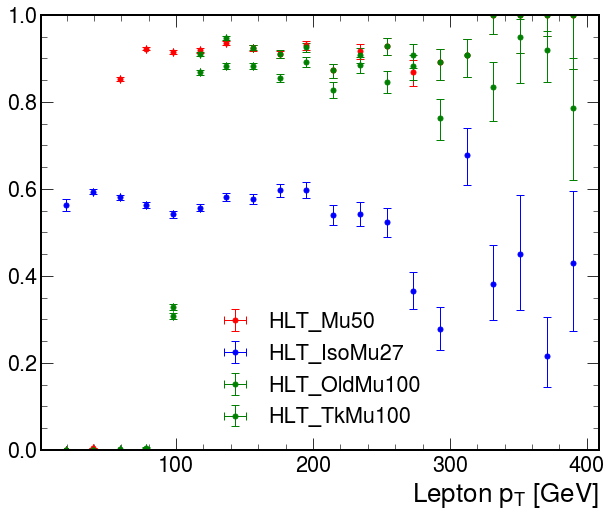

In [209]:
# now we plot trigger efficiency as function of jetpt
num_HLT_Mu50 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_Mu50", 'higgspt':sum}]
num_HLT_IsoMu27 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_IsoMu27", 'higgspt':sum}]
num_HLT_OldMu100 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_OldMu100", 'higgspt':sum}]
num_HLT_TkMu100 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_TkMu100", 'higgspt':sum}]

den = hists[{"region":"denominator", "channel":"mu", "trigger":sum, 'higgspt':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(figsize=(10,8))
hep.histplot(num_HLT_Mu50/den,
             #np.nan_to_num(num_HLT_Mu50/den, copy=False, nan=1), 
             ax = ax,
             color='red', 
             label="HLT_Mu50",
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_Mu50, den),
             capsize=4, 
             elinewidth=1,              
)
hep.histplot(num_HLT_IsoMu27/den, 
             #np.nan_to_num(num_HLT_IsoMu27/den, copy=False, nan=1),              
             ax = ax,
             color='blue', 
             label="HLT_IsoMu27",             
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_IsoMu27, den),
             capsize=4,  
             elinewidth=1, 
)
hep.histplot(num_HLT_OldMu100/den, 
             #np.nan_to_num(num_HLT_OldMu100/den, copy=False, nan=1),           
             ax = ax,
             color='green', 
             label="HLT_OldMu100",
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_OldMu100, den),    
             capsize=4,   
             elinewidth=1,              
)
hep.histplot(num_HLT_TkMu100/den, 
             #np.nan_to_num(num_HLT_TkMu100/den, copy=False, nan=1),           
             ax = ax,
             color='green', 
             label="HLT_TkMu100",
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_TkMu100, den),    
             capsize=4,   
             elinewidth=1,              
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig(f'trigger/leppt_mu.pdf');

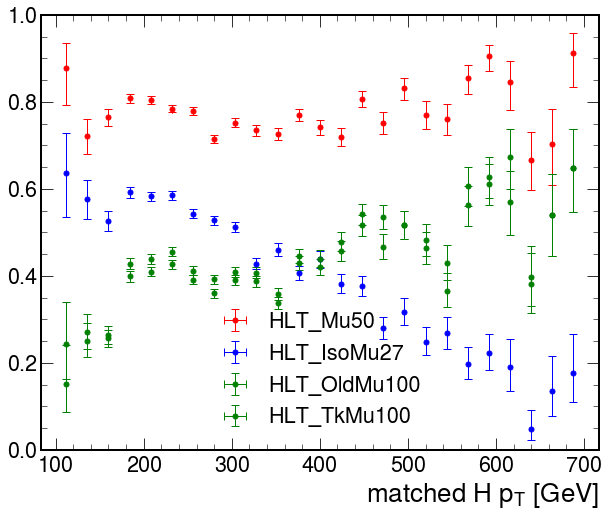

In [210]:
# now we plot trigger efficiency as function of jetpt
num_HLT_Mu50 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_Mu50", 'leppt':sum}]
num_HLT_IsoMu27 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_IsoMu27", 'leppt':sum}]
num_HLT_OldMu100 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_OldMu100", 'leppt':sum}]
num_HLT_TkMu100 = hists[{"region":"numerator", "channel":"mu", "trigger":"HLT_TkMu100", 'leppt':sum}]

den = hists[{"region":"denominator", "channel":"mu", "trigger":sum, 'leppt':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(figsize=(10,8))
hep.histplot(num_HLT_Mu50/den,
             #np.nan_to_num(num_HLT_Mu50/den, copy=False, nan=1), 
             ax = ax,
             color='red', 
             label="HLT_Mu50",
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_Mu50, den),
             capsize=4, 
             elinewidth=1,              
)
hep.histplot(num_HLT_IsoMu27/den, 
             #np.nan_to_num(num_HLT_IsoMu27/den, copy=False, nan=1),              
             ax = ax,
             color='blue', 
             label="HLT_IsoMu27",             
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_IsoMu27, den),
             capsize=4,  
             elinewidth=1, 
)
hep.histplot(num_HLT_OldMu100/den, 
             #np.nan_to_num(num_HLT_OldMu100/den, copy=False, nan=1),           
             ax = ax,
             color='green', 
             label="HLT_OldMu100",
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_OldMu100, den),    
             capsize=4,   
             elinewidth=1,              
)
hep.histplot(num_HLT_TkMu100/den, 
             #np.nan_to_num(num_HLT_TkMu100/den, copy=False, nan=1),           
             ax = ax,
             color='green', 
             label="HLT_TkMu100",
             histtype='errorbar', 
             yerr=get_yerr(num_HLT_TkMu100, den),    
             capsize=4,   
             elinewidth=1,              
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig(f'trigger/higgspt_mu.pdf');